In [1]:
%matplotlib inline
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import pandas as pd
import numpy as np
import heatmap as hm
import matplotlib.pyplot as plt
import math
import matplotlib.patches as mpatches
from matplotlib import cm

In [2]:
ivis = hm.IVIS()

In [3]:
#kind of similar to what I have in the dot plot notebook - 
#do I want to make this a function?

In [4]:
ivis.gt_df.describe()

,eventid,year,latitude,longitude,kills,wounds,casualties
count,1.567720e+05,156772.000000,156772.000000,156772.000000,156772.000000,156772.000000,156772.000000
mean,2.000541e+11,2000.474083,22.522501,23.512593,2.221156,2.806636,5.027792
std,1.298283e+09,12.982397,19.335023,59.170005,11.102675,21.686324,26.198865
min,1.970000e+11,1970.000000,-53.154613,-176.176447,0.000000,0.000000,0.000000
25%,1.989082e+11,1989.000000,8.592200,-0.126236,0.000000,0.000000,0.000000
50%,2.005071e+11,2005.000000,30.587291,38.650509,0.000000,0.000000,1.000000
75%,2.013060e+11,2013.000000,34.610591,67.584889,2.000000,1.000000,4.000000
max,2.015123e+11,2015.000000,74.633553,179.366667,1500.000000,5500.000000,5513.000000


In [5]:
bubble_chart_features = ['year', 'country', 'region', 'casualties']

gtd_bubble = ivis.gt_df[bubble_chart_features]

In [6]:
def create_range(series_to_group, group_size):
    '''Turns a series into groups of a specified size'''
    bins = np.arange(min(series_to_group) - group_size, max(series_to_group) + group_size, group_size)
    ranges = pd.cut(series_to_group, bins)
    ranges.name = series_to_group.name + ' ranges'
    return ranges

In [7]:
def replace_series_with_range(data, series_to_group, group_size):
    '''Removes year column and merges range column'''
    ranges = create_range(series_to_group, group_size)
    data_replaced = pd.concat([data, pd.DataFrame(ranges)], axis = 1).drop(series_to_group.name, 1)
    return data_replaced

gtd_bubble.head()

,year,country,region,casualties
0,1970,Dominican Republic,Central America & Caribbean,1
1,1970,Mexico,North America,0
2,1970,Philippines,Southeast Asia,1
3,1970,Greece,Western Europe,0
4,1970,Japan,East Asia,0


In [8]:
gtd_bubble = replace_series_with_range(gtd_bubble, gtd_bubble['year'], 5)
gtd_bubble.head()

,country,region,casualties,year ranges
0,Dominican Republic,Central America & Caribbean,1,"(1965, 1970]"
1,Mexico,North America,0,"(1965, 1970]"
2,Philippines,Southeast Asia,1,"(1965, 1970]"
3,Greece,Western Europe,0,"(1965, 1970]"
4,Japan,East Asia,0,"(1965, 1970]"


In [9]:
#Need to update dot plot with these functions

In [10]:
def group_by_columns(data, group_by_columns, column_to_agg):
    '''Takes a list of column names and a column to count and counts rows by those column name, including nulls'''
    all_columns = group_by_columns + [column_to_agg]
    data.loc[:, column_to_agg] = data.loc[:, column_to_agg].fillna(value=0)
    data = data.loc[:,all_columns]
    grouped = data.groupby(group_by_columns)
    return grouped

In [11]:
def sum_by_groups(grouped):
    '''Takes output of group function and sums data'''
    sums = grouped.sum().dropna()
    sums.columns = ['sum']
    return sums

In [12]:
def count_by_groups(grouped):
    '''Takes output of group function and counts data'''
    counts = grouped.count().dropna()
    counts.columns = ['count']
    return counts

In [80]:
#this doesn't use any of the instance attributes
def draw_legend(colors_legend):
    recs = []
    for key in list(colors_legend.keys()):
        recs.append(mpatches.Rectangle((0,0),1,1,fc=colors_legend[key], alpha = 0.5))
    plt.legend(recs,list(colors_legend.keys()),loc=4)

In [101]:
#Need to deal with error handling for all this stuff
class Bubble_Chart_Data():
    def __init__(self, data, bubble_id, color, user_filter, values):
        '''Defines attributes of the bubble chart'''
        self.data = data
        self.bubble_id = bubble_id
        self.color = color
        self.user_filter = user_filter
        self.values = values
        self.new_data = data
        self.groups = group_by_columns(self.data, [self.bubble_id], self.values)
        self.subgroups = group_by_columns(self.data, [self.bubble_id, self.color, self.user_filter], self.values)
        self.x_values = values
        self.y_values = values
    
    def count_by_subgroup(self):
        '''Uses group from init function to create a count'''
        return count_by_groups(self.subgroups)
        
    def sum_by_subgroup(self):
        '''Uses sum from init function to create a sum'''
        return sum_by_groups(self.subgroups)
    
    def aggregate_by_subgroup(self):
        '''Returns sum and count merged together'''
        self.new_data = pd.concat((self.count_by_subgroup(), self.sum_by_subgroup()), axis=1, join='outer')
        self.new_data.columns = ['occurrences', self.values]
        self.new_data.reset_index(level=self.color, inplace=True)
        
    def count_by_group(self):
        '''Returns the sum by groups (ignores user filters)'''
        return count_by_groups(self.groups)
    
    def set_bubble_size(self, bubble_size, new_col_name):
        '''bubble size must be a one-column dataframe or series with the bubble_id as the index'''
        self.new_data = pd.DataFrame(bubble_size).join(self.new_data, how='inner')
        self.new_data = self.new_data.rename(index=str, columns={bubble_size.columns[0]: new_col_name})
        self.bubble_size = new_col_name
        
    def set_x_axis_values(self, x_values):
        '''Stores the column name corresponding to the bubbles' values on the x-axis'''
        self.x_values = x_values
    
    def set_y_axis_values(self, y_values):
        '''Stores the column name corresponding to the bubbles' values on the y-axis'''
        self.y_values = y_values
        
    def add_color_dict(self):
        '''Creates a dictionary that maps the color variable to numbers'''
        #You can call this whenever without error, but once you aggregate again, the column will disappear
        #http://stackoverflow.com/questions/14885895/color-by-column-values-in-matplotlib
        color_cats = self.data[self.color].unique()
        colors = np.linspace(0, 1, len(color_cats))
        colordict = dict(zip(color_cats, colors))  
        self.new_data['color'] = self.new_data[self.color].apply(lambda x: colordict[x])
    
    def process_bubble_chart_data(self, x_values, y_values):
        '''Prepares bubble chart to be plotted'''
        self.aggregate_by_subgroup()
        self.set_bubble_size(self.count_by_group(), 'all-time occurrences')
        self.set_x_axis_values(x_values)
        self.set_y_axis_values(y_values)
        self.add_color_dict()
        self.new_data.reset_index(level=self.bubble_id, inplace=True)
        return bubble_chart
        
    def filter_for_user(self, user_input):
        '''Selects the part of the data that the user selected'''
        #This assumes you've already run agg by bubbleID, should also handle key error
        self.new_data = self.new_data.loc[user_input, :]
    
    def create_legend(self):
        '''Takes an object from the bubble chart data class and creates an appropriate legend. Must be called after process data'''
        grouped_by_color = group_by_columns(self.new_data, [self.color, 'color'], self.bubble_id)
        counted_by_color = count_by_groups(grouped_by_color)
        counted_by_color.reset_index(inplace=True)

        colors_legend = {}

        for i in range(0, len(counted_by_color)):
            colors_legend[counted_by_color[self.color][i]] = cm.viridis(counted_by_color['color'][i])

        return colors_legend
    
    def annotate(self):
        '''Labels the top 10 bubbles by the attribute that will be on the y-axis'''
        self.new_data.sort_values(self.y_values, ascending=False).iloc[0:20]
        for i in range(0, 10):

            offset_x = math.sqrt(self.new_data[self.bubble_size].iloc[i])/4
            offset_y = - math.sqrt(self.new_data[self.bubble_size].iloc[i])/25

            plt.annotate(self.new_data[self.bubble_id].iloc[i], 
                         xy = (self.new_data[self.x_values].iloc[i], self.new_data[self.y_values].iloc[i]),
                         xytext=(offset_x, offset_y),
                         textcoords='offset points',
                         color='darkslategrey')
    
    def format_axes_length(self, ax):
        '''Formats axes lengths according to range of values to present'''
        x_limit = math.ceil(max(self.new_data[self.x_values])/750)*750
        y_limit = math.ceil(max(self.new_data[self.y_values])/7500)*7500
        ax.set_xlim(xmin = -0.05*x_limit, xmax = x_limit )
        ax.set_ylim(ymin = -0.05*y_limit, ymax = y_limit )
    
    def format_labels(self, ax):
        '''Creates meaningful chart title and axis labels'''
        ax.set_title(str.title(self.x_values) + ' and ' + str.title(self.y_values) + ' by ' + str.title(self.bubble_id))
        ax.title.set_fontsize(15)
        ax.set_xlabel(str.title(self.x_values))
        ax.set_ylabel(str.title(self.y_values))
    
    def create_bubble_chart(self, year):
        '''Draws the bubble chart'''
        self.process_bubble_chart_data('occurrences', 'casualties')
        self.filter_for_user(construct_interval(year))
        self.new_data = self.new_data.sort_values(self.values, ascending=False)

        fig = plt.figure()
        ax = fig.add_subplot(1,1,1, axisbg='white')

        self.format_labels(ax)

        ax.scatter(self.new_data[self.x_values], 
                         self.new_data[self.y_values],
                         self.new_data[self.bubble_size]/5, 
                         c = self.new_data['color'], 
                         cmap = 'viridis', 
                         alpha = 0.5)

        self.new_data.sort_values(self.y_values, ascending=False).iloc[0:20]
        self.annotate()

        draw_legend(self.create_legend())

        self.format_axes_length(ax)
        fig = plt.gcf()
        fig.set_size_inches(18.5, 10.5)

        plt.show()

In [ ]:
#Not sure if I want to put all of these functions in the class. Could divide them into data prep and plotting

In [14]:
def construct_interval(year):
    return '('+ str(year - 5) + ', ' + str(year) + ']'

In [16]:
#http://stackoverflow.com/questions/26558816/matplotlib-scatter-plot-with-legend

In [102]:
bubble_chart = Bubble_Chart_Data(gtd_bubble, 'country', 'region', 'year ranges', 'casualties')

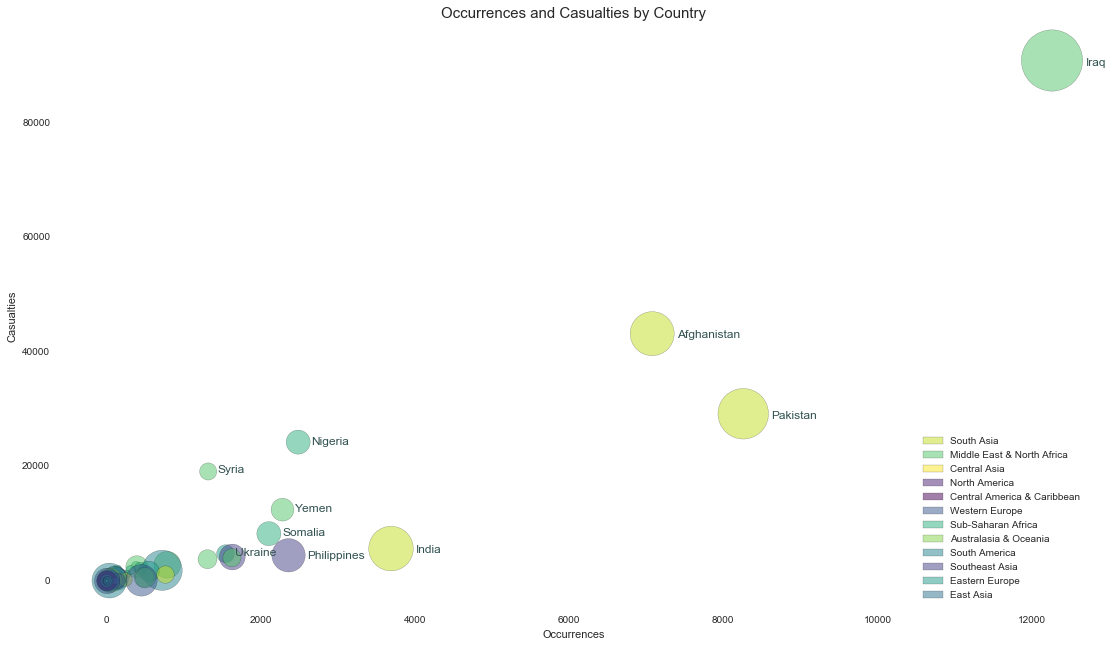

In [103]:
bubble_chart.create_bubble_chart(2015)

In [94]:
import matplotlib.pyplot as plt

from matplotlib import cm

def create_bubble_chart(year, bubble_chart):
    
    bubble_chart.process_bubble_chart_data('occurrences', 'casualties')
    
    bubble_chart.filter_for_user(construct_interval(year))
    
    bubble_chart.new_data = bubble_chart.new_data.sort_values(bubble_chart.values, ascending=False)
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, axisbg='white')
    
    format_labels(bubble_chart, ax)
    
    scatter = ax.scatter(bubble_chart.new_data[bubble_chart.x_values], 
                         bubble_chart.new_data[bubble_chart.y_values],
                         bubble_chart.new_data[bubble_chart.bubble_size]/5, 
                         c = bubble_chart.new_data['color'], 
                         cmap = 'viridis', 
                         alpha = 0.5)
    
    bubble_chart.new_data.sort_values(bubble_chart.y_values, ascending=False).iloc[0:20]
    
    annotate(bubble_chart)
    
    draw_legend(bubble_chart.create_legend())

    format_axes_length(bubble_chart, ax)
    
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    
    plt.show()

In [63]:
bubble_chart_yr = widgets.IntSlider(min=1975,max=2015,step=5,value=1995, width = '90%')

In [64]:
def Display_Your_BubbleChart():
    '''
    Allow users to interactively explore data information
    and customize the bubble chart
    '''
    interact(create_bubble_chart, year=bubble_chart_yr)

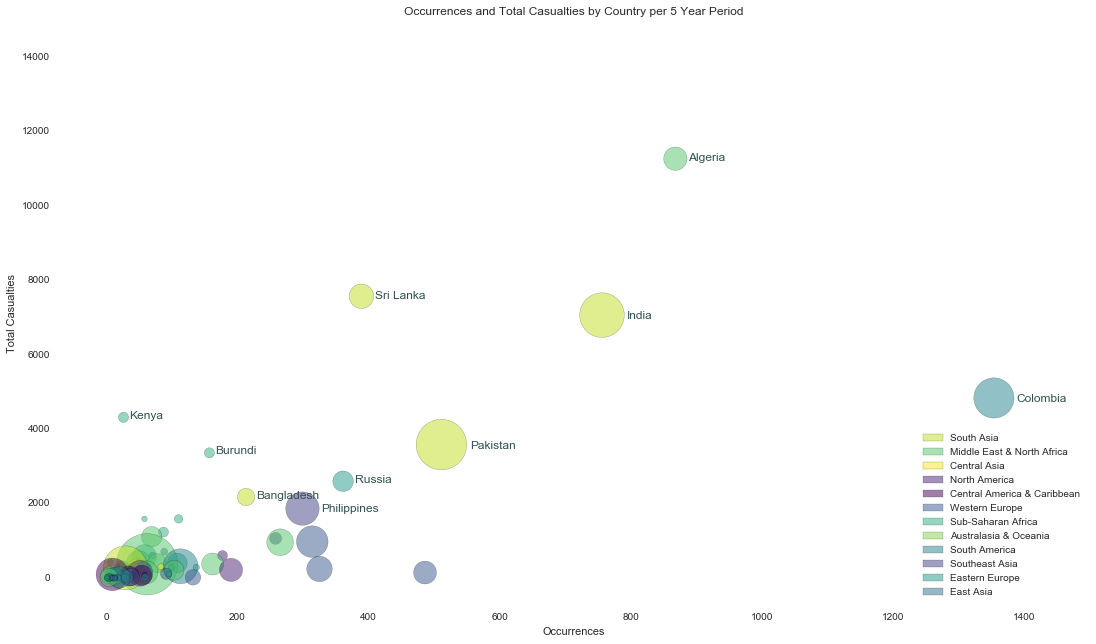

In [65]:
Display_Your_BubbleChart()

Also considered doing a bubble chart where the x axis is percentage change in # killed, y axis is percentage change in # occurrences, and size of bubble is # incidents

In [24]:
#this is useful in general, don't make it specific to bubble chart
def create_total(to_sum, sum_by):
    '''takes two series of the same length, sums one by the other, returns a series with the result'''
    data = pd.concat([sum_by, to_sum], axis = 1)
    totaled = pd.pivot_table(data, index = sum_by.name, aggfunc=sum)
    totaled.columns = ['total ' + to_sum.name]
    return pd.Series(totaled['total ' + to_sum.name])